In [122]:
import numpy

from numpy import random
from matplotlib import pyplot
from scipy import stats

_BASE_SEED = """This is a pretty long string. I am making some odd decisions with it?
Who shall say this is not a pretty entropic thing I'm rwriting, I tell you hwaht."""

In [123]:
def seed(s: str) -> int:
    return abs(hash(_BASE_SEED + s)) % (2 ** 32)

## 5.1, Discrete probability simulation

> Suppose that a basketball player has a 60% chance of making a shot, and he
> keeps taking shots until he misses two in a row. Also assume his shots are
> independent (so that each shot has 60% probability of success, no matter what
> happened before).
>
> (a) Write an R function to simulate this process.
>
> (b) Put the R function in a loop to simulate the process 1000 times. Use the
> simulation to estimate the mean and standard deviation of the total number of
> shots that the player will take, and plot a histogram representing the
> distribution of this random variable.
>
> (c) Using your simulations, make a scatterplot of the number of shots the
> player will take and the proportion of shots that are successes.

In [124]:
rng = random.default_rng(seed=seed('Example 5.1'))

Start with a manual implementation, just to satisfy the spirit of the problem:

In [125]:
def manual_implementation() -> int:
    misses = 0
    shots = 0
    while misses < 2:
        shots += 1
        if rng.random() > 0.6:
            misses += 1
    return shots    

In [126]:
manual_simulations = [manual_implementation() for _ in range(1000)]
print(f'Mean:     {numpy.mean(manual_simulations):0.2f}\nStd. Dev: {numpy.std(manual_simulations):0.2f}')

Mean:     5.20
Std. Dev: 2.83


In [127]:
def histogram_basketball(shot_counts: list[int]):
    fig = pyplot.figure(figsize=(7, 5))
    ax = fig.gca()
    ax.hist(shot_counts, bins=max(shot_counts), range=(0, max(shot_counts)),
            align='left')
    ax.set_xlabel('Number of shots')
    ax.set_ylabel('Number of simulations')
    ax.set_xticks(range(0, 1 + max(shot_counts)))
    ax.set_xlim(0, 1 + max(shot_counts))
    ax.grid()

In [128]:
def scatter_basketball(shot_counts: list[int]):
    # Add some jitter to the shot counts:
    xs = [rng.uniform(-0.15, 0.15) + count for count in shot_counts]
    # And also to the proportion:
    ys = [rng.uniform(-0.02, 0.02) + float(count - 2) / count for count in shot_counts]
    fig = pyplot.figure(figsize=(7, 5))
    ax = fig.gca()
    ax.set_xlabel('Shots taken')
    ax.set_ylabel('Success rate')
    ax.scatter(xs, ys, s=2, alpha=0.8)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.5, max(shot_counts) + 0.5)
    ax.set_xticks([xi for xi in range(max(shot_counts) + 1) if xi % 3 == 0])
    ax.grid()

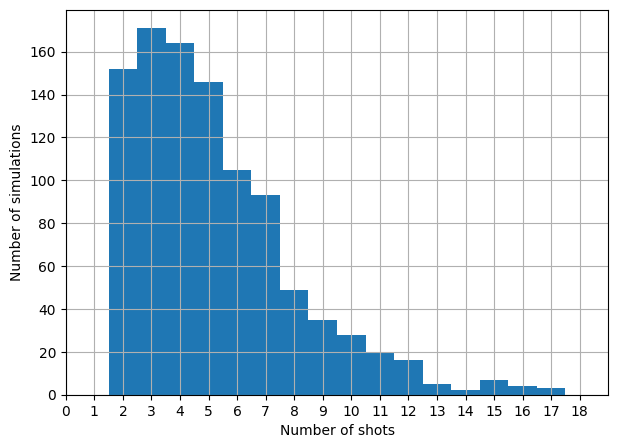

In [129]:
histogram_basketball(manual_simulations)

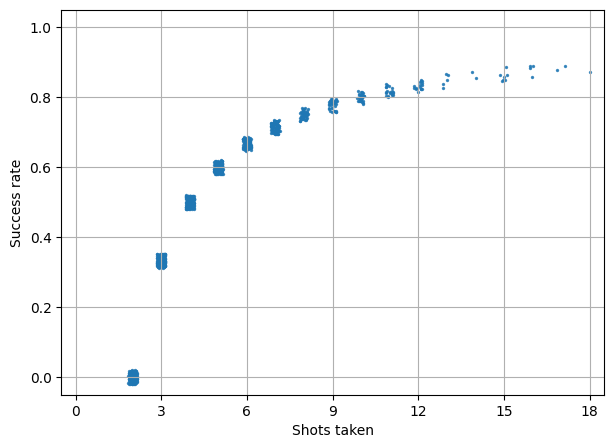

In [130]:
scatter_basketball(manual_simulations)

Now use the SciPy builtins for this (Numpy has perfectly suitable ones, too):

In [131]:
rng = random.default_rng(seed=seed('Example 5.dasfdsafdsfds'))
scipy_simulations = stats.nbinom.rvs(n=2, p=0.4, loc=2, size=1000, random_state=rng)
print(f'Mean:     {numpy.mean(scipy_simulations):0.2f}\nStd. Dev: {numpy.std(scipy_simulations):0.2f}')

Mean:     5.03
Std. Dev: 2.66


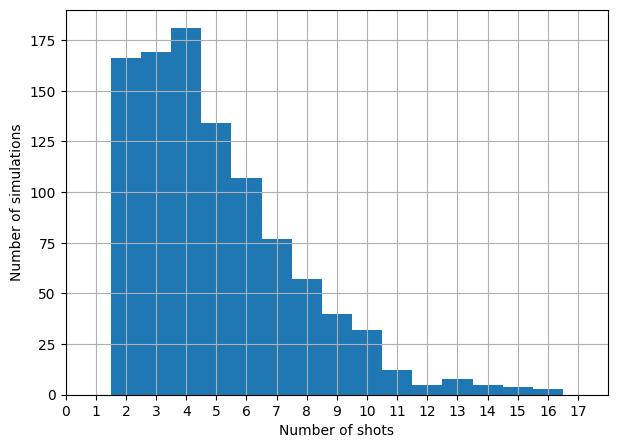

In [132]:
histogram_basketball(scipy_simulations)

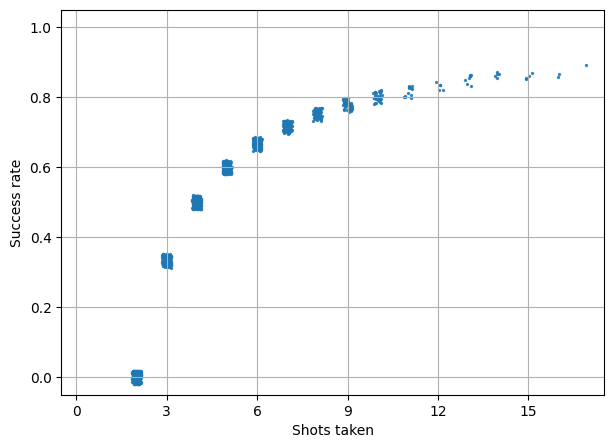

In [133]:
scatter_basketball(scipy_simulations)